In [2]:
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import wfdb
import glob

FOLDER_PATH = '24h-emgcg/'
PHYSIONET_PATH = 'cves/1.0.0/data/24h-electromyography'
PHYSIONET_DIR = 'cves'

In [3]:
# READ NUMBER OF RECORD EACH SIGNAL FROM PhysioNet server

# Fetch the list of records from PhysioNet
physio_records = wfdb.get_record_list(PHYSIONET_DIR)

# Get list of ecg-emg record from the list above by cut off the prefix
records = [record.split('/')[2] for record in physio_records if record.startswith("data/24h-electromyography/")]

records_samples = []

# Iterate over each record to read its header and extract the number of samples
for record_name in records:
    # Note: rdheader fetches the header file directly from PhysioNet if the full path is provided
    record_header = wfdb.rdheader(record_name, pn_dir=PHYSIONET_PATH)
    num_samples = record_header.sig_len
    records_samples.append((record_name, num_samples))

# Sort the records by the number of samples
sorted_records = sorted(records_samples, key=lambda x: x[1], reverse=True)

# Print the sorted list
for record, samples in sorted_records:
    print(f"Record '{record}' has {samples} samples.")


Record 's0187-05040712' has 57970170 samples.
Record 's0169-04051405' has 57910571 samples.
Record 's0064-05081806' has 57574788 samples.
Record 's0166-05031009' has 57547812 samples.
Record 's0160-04052808' has 57122536 samples.
Record 's0295-06100502' has 56833248 samples.
Record 's0221-06082211' has 56669814 samples.
Record 's0068-05022418' has 56574893 samples.
Record 's0331-07031505' has 56486760 samples.
Record 's0388-07103006' has 56385486 samples.
Record 's0176-04060218' has 56383898 samples.
Record 's0121-04042802' has 56360117 samples.
Record 's0399-07120405' has 56313162 samples.
Record 's0178-05041206' has 56097300 samples.
Record 's0197-05060906' has 55925100 samples.
Record 's0397-08012205' has 55897422 samples.
Record 's0163-04060412' has 55877515 samples.
Record 's0153-05021019' has 55763310 samples.
Record 's0324-07030106' has 55724226 samples.
Record 's0175-05030326' has 55471668 samples.
Record 's0321-07022206' has 55360422 samples.
Record 's0340-07050204' has 553297

In [4]:
# CONVERT TO p_signal FILES USING 2 CHANNEL ecg_0 vs ecg_1

# List all .hea files in the folder
record_files = [f for f in os.listdir(FOLDER_PATH) if f.endswith('.hea')]

# Initialize an array to hold the names of records missing .dat files
records_missing_dat = []

records_exist = []

records_header_error = []

for record_file in record_files:
    # Extract the base name of the record (without extension)
    record_name = os.path.splitext(record_file)[0]
    
    # Check if the corresponding .dat file exists
    if not os.path.exists(os.path.join(FOLDER_PATH, f"{record_name}.dat")):
        records_missing_dat.append(record_name)
        continue  # Skip to the next record
    
    # Define the path for the output .p_signal file
    output_file_path = os.path.join(FOLDER_PATH, f"{record_name}_p_signal.txt")
    
    # Check if the .p_signal file already exists
    if os.path.exists(output_file_path):
        records_exist.append(record_file)
        continue  # Skip to the next record if .p_signal file exists
    
    # Read the specified channels (0 and 1) from the record
    try:
        record = wfdb.rdrecord(os.path.join(FOLDER_PATH, record_name), channels=[0, 1])
    except Exception as e:
        # Check if the exception is related to file not found or header syntax error
        if isinstance(e, FileNotFoundError):
            records_missing_dat.append(record_name)
        else:
            print(f"Error processing {record_name}: {str(e)}")
            records_header_error.append(record_name)
        continue
    
    # Extract the signals for channels 0 and 1
    signals = record.p_signal
    
    # Write the signals to the output file
    with open(output_file_path, 'w') as file:
        for signal in signals:
            file.write(f"{signal[0]}\t{signal[1]}\n")

print("Conversion completed.")
if records_missing_dat:
    print("The following records were skipped due to missing .dat files:")
    print(records_missing_dat)
if records_header_error:
    print("The following records had header syntax errors:")
    print(records_header_error)
print(f"Number of records converted: {len(record_files) - len(records_missing_dat) - len(records_header_error)}")

Conversion completed.
Number of records converted: 0


In [5]:
# DELETE ALL .dat .hea .maker files

# Correct extension from '.marker' to '.maker'
extensions = ['.dat', '.hea', '.marker']

# Function to check for corresponding _p_signal.txt file and delete if exists
def delete_files_if_txt_exists(folder_path):
    for ext in extensions:
        file_pattern = os.path.join(folder_path, f'*{ext}')
        files = glob.glob(file_pattern)
        for file_path in files:
            # Construct the base name and check for the corresponding _p_signal.txt file
            base_name = os.path.splitext(os.path.basename(file_path))[0]
            txt_file_path = os.path.join(folder_path, f'{base_name}_p_signal.txt')
            if os.path.exists(txt_file_path):
                # Attempt to delete files with the specified extensions
                try:
                    os.remove(file_path)
                    print(f"Deleted: {file_path}")
                except OSError as e:
                    print(f"Error: {file_path} - {e.strerror}")

delete_files_if_txt_exists(FOLDER_PATH)

In [6]:
# CONVERT BY CALL PHYSIONET

# Ensure the local save directory exists
os.makedirs(FOLDER_PATH, exist_ok=True)

for record_name in records:
    # Define the path for the expected .p_signal output file
    output_file_path = os.path.join(FOLDER_PATH, f"{record_name}_p_signal.txt")
    
    # Check if the .p_signal file already exists
    if os.path.exists(output_file_path):
        print(f"File {output_file_path} already exists. Skipping...")
        continue

    # Read the specified channels (0 and 1) from the record directly from PhysioNet
    # Note: This step requires an internet connection and access permissions to the data
    record = wfdb.rdrecord(record_name, pn_dir=PHYSIONET_PATH, channels=[0, 1])

    # Extract the signals for channels 0 and 1
    signals = record.p_signal

    # Write the signals to the output file
    with open(output_file_path, 'w') as file:
        for signal in signals:
            # Write each signal sample to the file, separated by a tab
            file.write(f"{signal[0]}\t{signal[1]}\n")

print("Conversion completed. Check the local directory for the .p_signal files.")


File 24h-emgcg/s0030-04051907_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0030-04051908_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0044-05062806_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0044-05062807_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0064-05081805_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0064-05081806_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0067-05040508_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0067-05040509_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0067-05040510_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0067-05040511_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0068-05022417_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0068-05022418_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0121-04042801_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0121-04042802_p_signal.txt already exists. Skipping...
File 2

In [19]:
# MAKE DATA FROM uV TO mV

# Iterate over all files in the specified directory
for filename in os.listdir(FOLDER_PATH):
    # Construct the full file path
    file_path = os.path.join(FOLDER_PATH, filename)
    
    # Check if it's a file
    if os.path.isfile(file_path):
        # Open the file, read the lines, perform division, and collect modified lines
        with open(file_path, 'r') as file:
            modified_lines = ['\t'.join([str(float(value)/1000) for value in line.split()]) + '\n' for line in file]
        
        # Write the modified lines back to the file
        with open(file_path, 'w') as file:
            file.writelines(modified_lines)
            

print("All p_signal files have been modified.")

: 

Main names of files: ['s0322-07052204', 's0242-06012405', 's0184-05091311', 's0335-07040503', 's0231-05111709', 's0175-05030325', 's0376-07091805', 's0221-06082208', 's0208-05102508', 's0153-05021018', 's0225-06022111', 's0218-05110113', 's0351-07062105', 's0230-06013111', 's0197-05060906', 's0358-07071203', 's0358-07071204', 's0247-06050205', 's0376-07091804', 's0221-06082209', 's0208-05102509', 's0184-05091310', 's0239-06012607', 's0164-06033006', 's0157-05062311', 's0322-07052205', 's0231-05111708', 's0232-06060108', 's0204-05092907', 's0230-06013110', 's0351-07062104', 's0354-07051506', 's0187-05040711', 's0164-06033107', 's0218-05110112', 's0331-07031501', 's0210-05092012', 's0153-05021019', 's0030-04051907', 's0132-04102801', 's0207-05090814', 's0215-06030712', 's0305-06113004', 's0361-07080906', 's0166-05031008', 's0352-07060705', 's0305-06113003', 's0214-05110807', 's0352-07060702', 's0154-05050307', 's0160-04052807', 's0174-05062113', 's0336-07041701', 's0348-07052402', 's0221

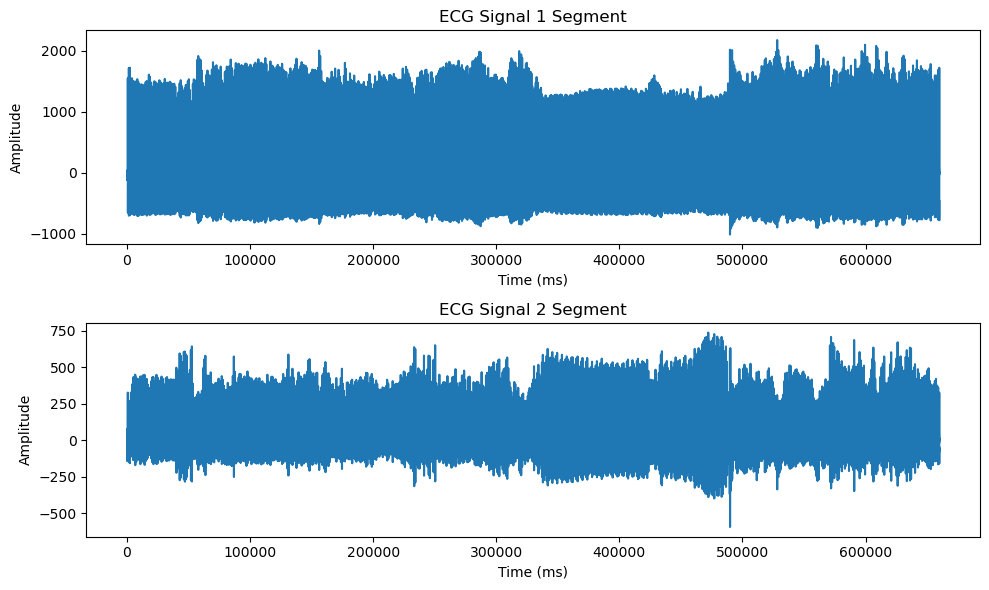

In [14]:
# GET LIST OF PREFIX TXT NAME

def get_main_names_of_files(FOLDER_PATH):
    file_names = os.listdir(FOLDER_PATH)
    main_names = [name.split('_p_signal.txt')[0] for name in file_names if name.endswith('_p_signal.txt')]
    return main_names

# PLOT SIGNAL IN RANGE(m , n) BY FILENAME
def plot_ecg_signal(main_name_of_file, n, m=0):
    # start m end n
    file_path = os.path.join(FOLDER_PATH, f'{main_name_of_file}_p_signal.txt')
    
    if not os.path.exists(file_path):
        print(f'File {file_path} does not exist.')
        return
    
    try:
        # Load the data with a maximum of 'n' rows
        total_data = np.loadtxt(file_path, max_rows=n)
        total_rows = total_data.shape[0]
        
        if m < 0 or n > total_rows or m >= n:
            raise ValueError(f"Invalid range: {m} to {n}. File contains {total_rows} rows.")
        
        # Since numpy.loadtxt doesn't support loading a slice directly, we use slicing after loading
        data_segment = total_data[m:n, :]
        
    except Exception as e:
        print(f"Error reading the file: {e}")
        return
    
    # Time array for the segment
    time = np.arange(m, n) * 1  # 1 ms per sample
    
    # Plotting
    plt.figure(figsize=(10, 6))
    
    plt.subplot(2, 1, 1)
    plt.plot(time, data_segment[:, 0])
    plt.title('ECG Signal 1 Segment')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (mV)')
    
    plt.subplot(2, 1, 2)
    plt.plot(time, data_segment[:, 1])
    plt.title('ECG Signal 2 Segment')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (mV)')
    
    plt.tight_layout()
    plt.show()

def count_rows_in_file(prefix, directory):
    suffix = '_p_signal.txt'
    filename = prefix + suffix
    file_path = os.path.join(directory, filename)
    
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
            return len(lines)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None

names = get_main_names_of_files(FOLDER_PATH)

print("Main names of files:", names)

plot_ecg_signal('s0402-08010704', 660000, 0)


In [12]:
prefix = 's0402-08010704'
row_count = count_rows_in_file(prefix, FOLDER_PATH)

if row_count is not None:
    print(f"{prefix + '_p_signal.txt'}: {row_count} rows")
else:
    print(f"{prefix + '_p_signal.txt'}: File does not exist.")

s0402-08010704_p_signal.txt: 48472440 rows


In [6]:
MAP = {}
for name in names:
    row_count = count_rows_in_file(name, FOLDER_PATH)
    MAP[name + '_p_signal.txt'] = row_count

In [9]:
# print("Sorted by Key:")
# sorted_by_key = dict(sorted(MAP.items()))
# for name, count in sorted_by_key.items():
#     print(f"{name}: {count} rows")
    
print("\nSorted by Value:")
sorted_by_value = dict(sorted(MAP.items(), key=lambda item: item[1]))
for name, count in sorted_by_value.items():
    print(f"{name}: {count} rows")


Sorted by Value:
s0164-06033005_p_signal.txt: 12 rows
s0221-06082203_p_signal.txt: 6888 rows
s0221-06082202_p_signal.txt: 6978 rows
s0221-06082204_p_signal.txt: 7650 rows
s0337-07032901_p_signal.txt: 9240 rows
s0221-06082208_p_signal.txt: 16164 rows
s0221-06082201_p_signal.txt: 16404 rows
s0337-07032903_p_signal.txt: 18996 rows
s0221-06082205_p_signal.txt: 21630 rows
s0321-07022204_p_signal.txt: 21912 rows
s0248-06041806_p_signal.txt: 25224 rows
s0337-07032902_p_signal.txt: 25500 rows
s0221-06082206_p_signal.txt: 35136 rows
s0247-06050206_p_signal.txt: 41886 rows
s0331-07031502_p_signal.txt: 49002 rows
s0067-05040509_p_signal.txt: 49530 rows
s0352-07060701_p_signal.txt: 52584 rows
s0277-06090701_p_signal.txt: 56850 rows
s0321-07022202_p_signal.txt: 72534 rows
s0331-07031503_p_signal.txt: 80868 rows
s0352-07060702_p_signal.txt: 81714 rows
s0336-07041701_p_signal.txt: 95466 rows
s0321-07022201_p_signal.txt: 128148 rows
s0321-07022203_p_signal.txt: 132966 rows
s0331-07031501_p_signal.txt

In [8]:
# SKIPPING FIRST AND LAST 30 MINS OF EACH SIGNAL
directory = 'test/'

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('_p_signal.txt'):
        file_path = os.path.join(directory, filename)
        
        # Read the content of the file, skipping the first and last 1.8M rows
        with open(file_path, 'r') as file:
            lines = file.readlines()
        
        # Skip the first 1.8M rows and the last 1.8M rows
        trimmed_lines = lines[1800000:-1800000]
        
        # Override the file with the trimmed content
        with open(file_path, 'w') as file:
            file.writelines(trimmed_lines)
        
        print(f"Processed and trimmed: {filename}")

print("All applicable .p_signal files have been trimmed.")


Processed and trimmed: s0402-08010704_p_signal.txt
All applicable .p_signal files have been trimmed.
